In [1]:
# Basic imports
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
db_path = "../data/covid.db"
conn = sqlite3.connect(db_path)


In [2]:
# 1) Load the cleaned US daily data from the SQLite table
query_all = """
SELECT *
FROM us_daily_cleaned
ORDER BY date;
"""

# Parse date as datetime
df = pd.read_sql_query(query_all, conn, parse_dates=["date"])

# Quick overview of the dataframe
print(df.head())
print(df.info())

# Basic statistical summary (numeric columns)
summary_stats = df.describe()
print(summary_stats)


        date  states  positive  negative  hospitalizedCurrently  \
0 2020-01-13       1       0.0       0.0                    0.0   
1 2020-01-14       1       0.0       0.0                    0.0   
2 2020-01-15       1       0.0       0.0                    0.0   
3 2020-01-16       1       0.0       0.0                    0.0   
4 2020-01-17       1       0.0       0.0                    0.0   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                     0.0             0.0              0.0   
1                     0.0             0.0              0.0   
2                     0.0             0.0              0.0   
3                     0.0             0.0              0.0   
4                     0.0             0.0              0.0   

   onVentilatorCurrently  onVentilatorCumulative  ...  totalTestResults  \
0                    0.0                     0.0  ...               0.0   
1                    0.0                     0.0  ...               0.0   

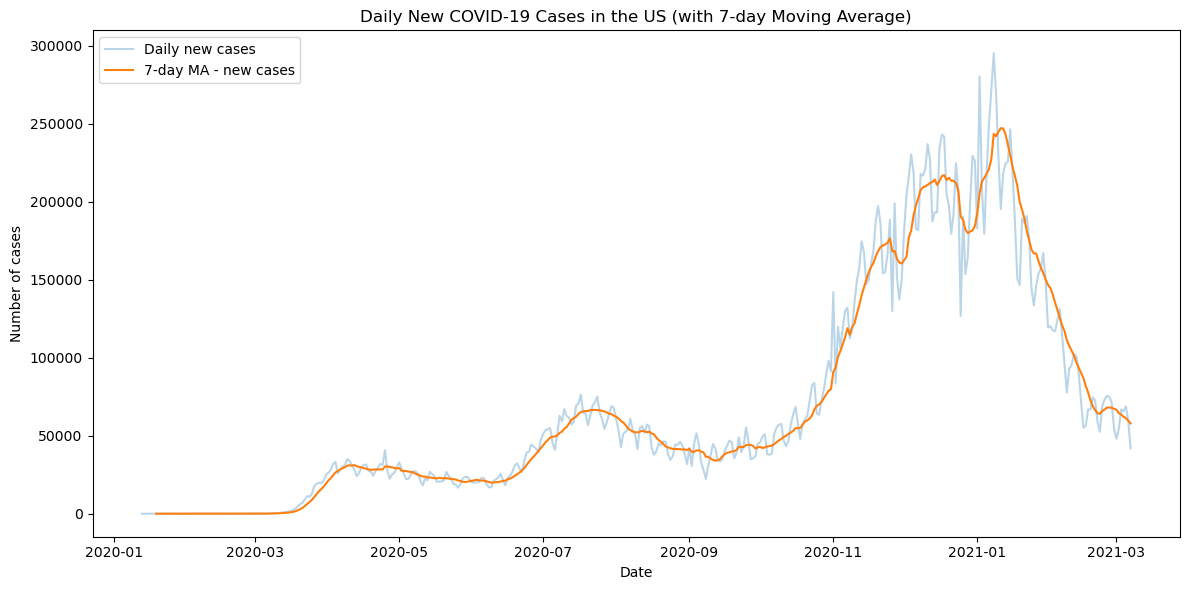

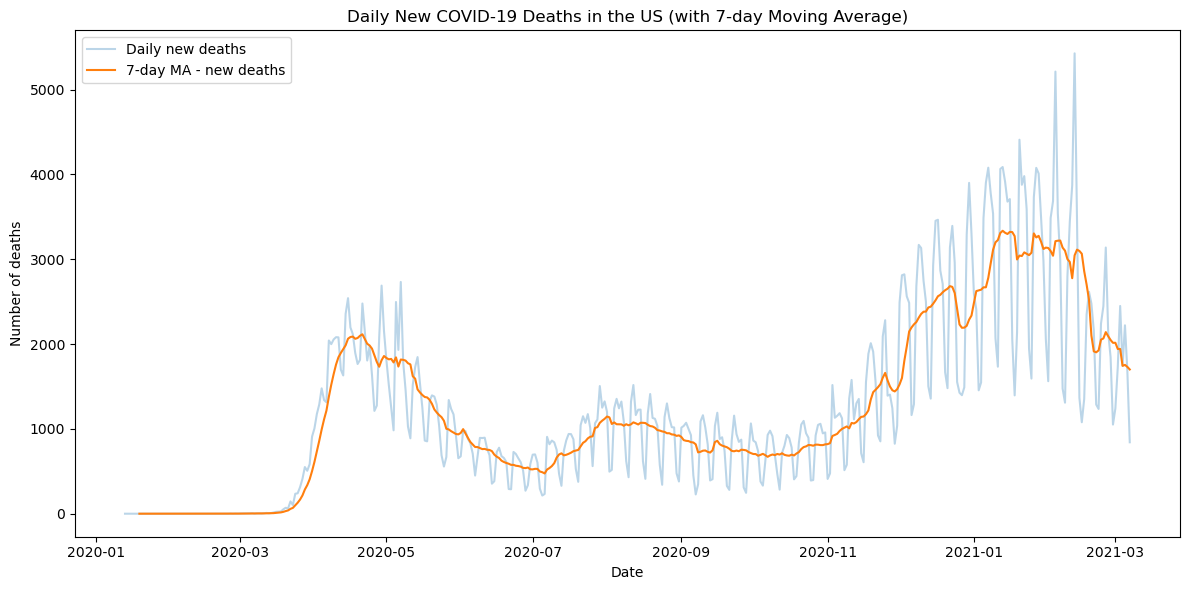

In [3]:
# 2) Query the daily new cases and deaths using SQL
query_cases_deaths = """
SELECT
    date,
    positiveIncrease,
    deathIncrease,
    totalTestResultsIncrease
FROM us_daily_cleaned
ORDER BY date;
"""

cases_df = pd.read_sql_query(query_cases_deaths, conn, parse_dates=["date"])

# Add 7-day moving averages in Python
cases_df = cases_df.sort_values("date").reset_index(drop=True)
cases_df["positiveIncrease_ma7"] = cases_df["positiveIncrease"].rolling(7).mean()
cases_df["deathIncrease_ma7"] = cases_df["deathIncrease"].rolling(7).mean()

# Plot daily new cases and 7-day MA
plt.figure(figsize=(12, 6))
plt.plot(cases_df["date"], cases_df["positiveIncrease"], alpha=0.3, label="Daily new cases")
plt.plot(cases_df["date"], cases_df["positiveIncrease_ma7"], label="7-day MA - new cases")
plt.xlabel("Date")
plt.ylabel("Number of cases")
plt.title("Daily New COVID-19 Cases in the US (with 7-day Moving Average)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot daily new deaths and 7-day MA
plt.figure(figsize=(12, 6))
plt.plot(cases_df["date"], cases_df["deathIncrease"], alpha=0.3, label="Daily new deaths")
plt.plot(cases_df["date"], cases_df["deathIncrease_ma7"], label="7-day MA - new deaths")
plt.xlabel("Date")
plt.ylabel("Number of deaths")
plt.title("Daily New COVID-19 Deaths in the US (with 7-day Moving Average)")
plt.legend()
plt.tight_layout()
plt.show()


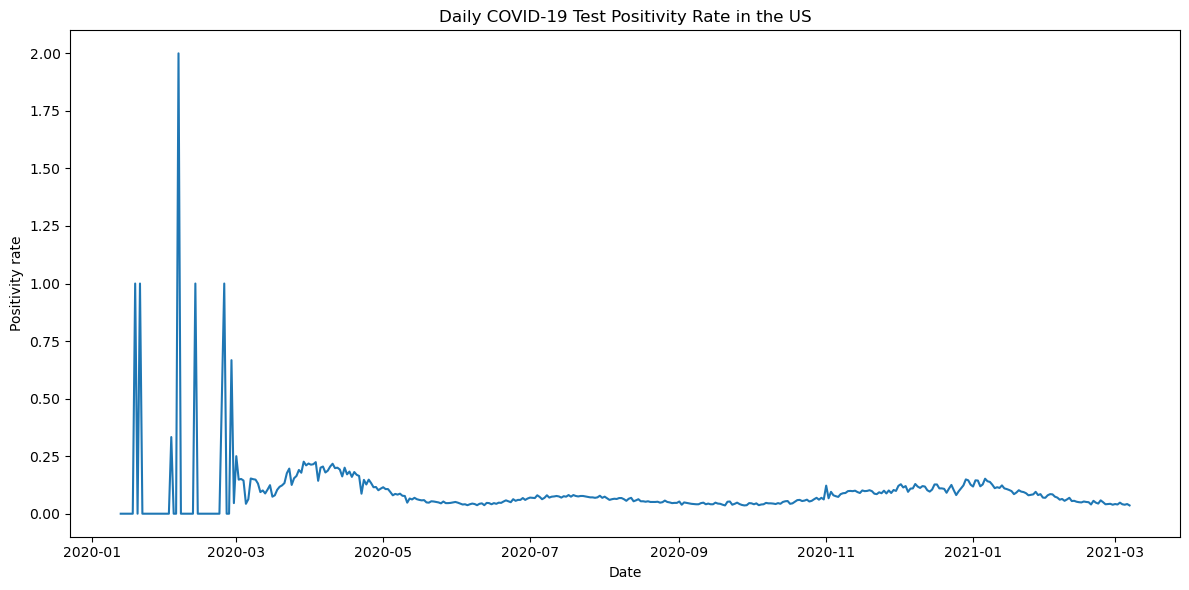

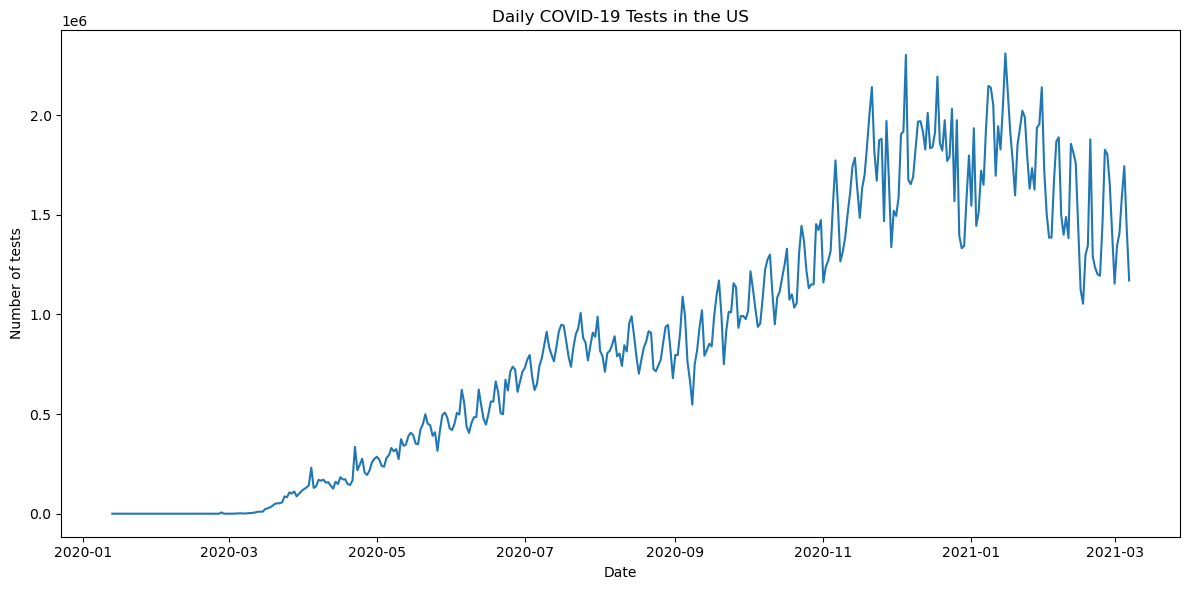

,period,avg_positivity_rate,avg_daily_tests
0,early_2020_until_April,0.155587,6.134141e+04
1,late_2020_from_November,0.090465,1.680935e+06


In [4]:
# 3) Query positivity rate and test volume
query_pos_rate = """
SELECT
    date,
    totalTestResultsIncrease,
    positivityRate
FROM us_daily_cleaned
ORDER BY date;
"""

pos_df = pd.read_sql_query(query_pos_rate, conn, parse_dates=["date"])
pos_df = pos_df.sort_values("date").reset_index(drop=True)

# Plot positivity rate over time
plt.figure(figsize=(12, 6))
plt.plot(pos_df["date"], pos_df["positivityRate"])
plt.xlabel("Date")
plt.ylabel("Positivity rate")
plt.title("Daily COVID-19 Test Positivity Rate in the US")
plt.tight_layout()
plt.show()

# Plot tests per day
plt.figure(figsize=(12, 6))
plt.plot(pos_df["date"], pos_df["totalTestResultsIncrease"], label="Daily tests")
plt.xlabel("Date")
plt.ylabel("Number of tests")
plt.title("Daily COVID-19 Tests in the US")
plt.tight_layout()
plt.show()

# Create a summary DataFrame: early vs late periods
early_mask = pos_df["date"] <= "2020-04-30"
late_mask = pos_df["date"] >= "2020-11-01"

pos_summary = pd.DataFrame({
    "period": ["early_2020_until_April", "late_2020_from_November"],
    "avg_positivity_rate": [
        pos_df.loc[early_mask, "positivityRate"].mean(),
        pos_df.loc[late_mask, "positivityRate"].mean()
    ],
    "avg_daily_tests": [
        pos_df.loc[early_mask, "totalTestResultsIncrease"].mean(),
        pos_df.loc[late_mask, "totalTestResultsIncrease"].mean()
    ]
})

pos_summary


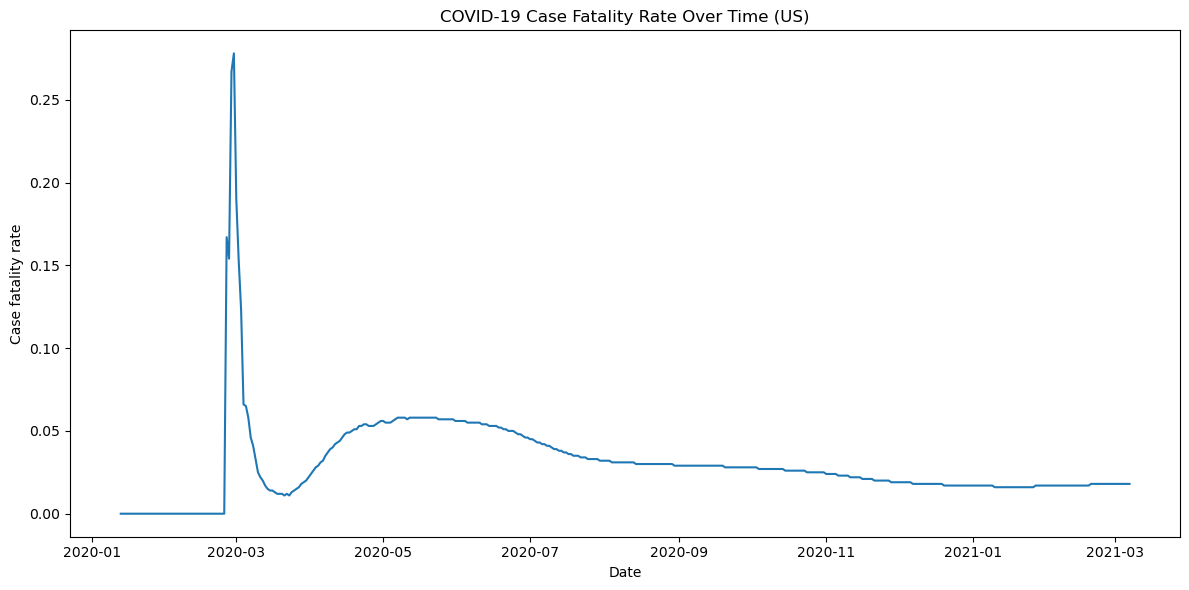

,period,avg_case_fatality_rate
0,early_2020_until_April,0.030459
1,late_2020_from_November,0.018276


In [5]:
# 4) Query case fatality rate
query_cfr = """
SELECT
    date,
    caseFatalityRate
FROM us_daily_cleaned
ORDER BY date;
"""

cfr_df = pd.read_sql_query(query_cfr, conn, parse_dates=["date"])
cfr_df = cfr_df.sort_values("date").reset_index(drop=True)

# Plot case fatality rate over time
plt.figure(figsize=(12, 6))
plt.plot(cfr_df["date"], cfr_df["caseFatalityRate"])
plt.xlabel("Date")
plt.ylabel("Case fatality rate")
plt.title("COVID-19 Case Fatality Rate Over Time (US)")
plt.tight_layout()
plt.show()

# Summarize early vs late CFR
early_mask = cfr_df["date"] <= "2020-04-30"
late_mask = cfr_df["date"] >= "2020-11-01"

cfr_summary = pd.DataFrame({
    "period": ["early_2020_until_April", "late_2020_from_November"],
    "avg_case_fatality_rate": [
        cfr_df.loc[early_mask, "caseFatalityRate"].mean(),
        cfr_df.loc[late_mask, "caseFatalityRate"].mean()
    ]
})

cfr_summary


In [6]:
# 5) Create a combined DataFrame for correlation analysis
query_corr = """
SELECT
    date,
    positiveIncrease,
    totalTestResultsIncrease,
    positivityRate
FROM us_daily_cleaned
ORDER BY date;
"""

corr_df = pd.read_sql_query(query_corr, conn, parse_dates=["date"])
corr_df = corr_df.sort_values("date").reset_index(drop=True)

# Compute correlation matrix for selected variables
corr_matrix = corr_df[["positiveIncrease",
                       "totalTestResultsIncrease",
                       "positivityRate"]].corr()

corr_matrix


,positiveIncrease,totalTestResultsIncrease,positivityRate
positiveIncrease,1.000000,0.887622,-0.006760
totalTestResultsIncrease,0.887622,1.000000,-0.125418
positivityRate,-0.006760,-0.125418,1.000000
